In [18]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory pathsa
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))


print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


In [19]:
import cobra
import os
import pandas as pd
import cameo
import wget
import ssl
from scipy.stats import pearsonr


#E. coli model:
ssl._create_default_https_context = ssl._create_unverified_context
wget.download("https://raw.githubusercontent.com/BenjaSanchez/notebooks/master/e_coli_simulations/eciML1515.xml")
eColi_Model = cobra.io.read_sbml_model("eciML1515.xml")
os.remove("eciML1515.xml")


# proteomics data:
proteomics_dataset = f"{INTERMEDIATE}/proteomics/proteomics_concentrations.csv"
weights_location = f"{INTERMEDIATE}/proteomics/proteomics_masses.csv"

In [20]:
from collections import namedtuple
from cobra.medium.boundary_types import find_external_compartment
from cobra.io.dict import reaction_to_dict
import pandas as pd
import numpy as np

In [21]:
from simulations.modeling.driven import (
    adjust_fluxes2model,
    flexibilize_proteomics,
    minimize_distance,
)

In [35]:
exchange_reaction = "50 mM NaCl"
exchange_reaction_lowercase = "50mmnacl"


In [23]:
def reset_real_proteomics(proteomics_dataset):
    '''loads set of proteomics data from the provided dataset file into dict of lists'''
    data = pd.read_csv(proteomics_dataset, index_col="UP")  # yeast
    data_dict = {}
    for i in range(0,data.shape[1], 3):
        uncertainty = data.iloc[:,i:i+3].std(axis=1)
        uncertainty_name = data.columns[i]+ "_uncertainty"
        data[uncertainty_name] = uncertainty
        data_dict[data.columns[i]] = [{'identifier':data.index[j], 'measurement':data.iloc[j,i], 'uncertainty':data[uncertainty_name][j] }\
         for j in range(0, len(data.iloc[:,i]))]
        data_dict[data.columns[i+1]] = [{'identifier':data.index[j], 'measurement':data.iloc[j,i+1], 'uncertainty':data[uncertainty_name][j] }\
         for j in range(0, len(data.iloc[:,i+1]))]
        data_dict[data.columns[i+2]] = [{'identifier':data.index[j], 'measurement':data.iloc[j,i+2], 'uncertainty':data[uncertainty_name][j] }\
         for j in range(0, len(data.iloc[:,i+2]))]
    return data_dict



In [24]:
proteomics_data = reset_real_proteomics(proteomics_dataset)

growth_rates = pd.read_csv(f"{RAW_INTERNAL}/proteomics/growth_conditions.csv")
growth_rates = growth_rates.drop(growth_rates.columns.difference(['Growth condition','Growth rate (h-1)', 'Stdev']), 1)
growth_rates = growth_rates.drop([0,1], axis=0)

In [25]:

def find_exchange_rxn(compound, model):
    exchange_reactions = [i for i in model.reactions if "EX" in i.id]
    compound_ex_rxn = [i for i in exchange_reactions if compound in i.name]
    compound_ex_rxn = [i for i in compound_ex_rxn if len(list(i._metabolites.keys())) == 1 \
                       & (list(i._metabolites.values())[0] == 1.0) \
                        & (list(i._metabolites.keys())[0].name == compound + " [extracellular space]")]
    return compound_ex_rxn


# find Pyruvate
ac_ex = find_exchange_rxn(exchange_reaction, eColi_Model)
print(ac_ex)
model = eColi_Model

# minimal medium with pyruvate
# pyruvate_growth_rate = list(growth_rates['Growth rate (h-1)'].loc[growth_rates['Growth condition'] == "Acetate"])[0]
# model = eColi_Model.copy()
# medium = model.medium
# medium.pop("EX_glc__D_e_REV", None)



# medium[f'{ac_ex[0].id}'] = 10
# model.medium = medium
# pyr_model.medium = minimal_medium(pyr_model).to_dict()
print(model.optimize())


[]
<Solution 0.877 at 0x131bbc5c0>


In [36]:
# Flexibilize proteomics

ec_model_1 = model
ec_model_2 = model
ec_model_3 = model

# first 
print("Number of proteins originally: ", len(proteomics_data[exchange_reaction_lowercase]))
growth_rate = {"measurement":float(list(growth_rates['Growth rate (h-1)'].loc[growth_rates['Growth condition'] == "Osmotic-stress glucose3"])[0]),\
    "uncertainty":float(list(growth_rates['Stdev'].loc[growth_rates['Growth condition'] == "Osmotic-stress glucose3"])[0])}
new_growth_rate, new_proteomics, warnings = flexibilize_proteomics(ec_model_1,  "BIOMASS_Ec_iML1515_core_75p37M", growth_rate, proteomics_data[exchange_reaction_lowercase], [])
print("Number of proteins incorporated: ", len(new_proteomics))

# first 
print("Number of proteins originally: ", len(proteomics_data[exchange_reaction_lowercase + "1"]))
growth_rate = {"measurement":float(list(growth_rates['Growth rate (h-1)'].loc[growth_rates['Growth condition'] == "Osmotic-stress glucose3"])[0]),\
    "uncertainty":float(list(growth_rates['Stdev'].loc[growth_rates['Growth condition'] == "Osmotic-stress glucose3"])[0])}
new_growth_rate, new_proteomics, warnings = flexibilize_proteomics(ec_model_2,  "BIOMASS_Ec_iML1515_core_75p37M", growth_rate, proteomics_data[exchange_reaction_lowercase + "1"], [])
print("Number of proteins incorporated: ", len(new_proteomics))

# first 
print("Number of proteins originally: ", len(proteomics_data[exchange_reaction_lowercase + "2"]))
growth_rate = {"measurement":float(list(growth_rates['Growth rate (h-1)'].loc[growth_rates['Growth condition'] == "Osmotic-stress glucose3"])[0]),\
    "uncertainty":float(list(growth_rates['Stdev'].loc[growth_rates['Growth condition'] == "Osmotic-stress glucose3"])[0])}
new_growth_rate, new_proteomics, warnings = flexibilize_proteomics(ec_model_3,  "BIOMASS_Ec_iML1515_core_75p37M", growth_rate, proteomics_data[exchange_reaction_lowercase + "2"], [])
print("Number of proteins incorporated: ", len(new_proteomics))


Number of proteins originally:  2058
Number of proteins incorporated:  1995
Number of proteins originally:  1995
Number of proteins incorporated:  1995
Number of proteins originally:  1995
Number of proteins incorporated:  1995


# Extraction of the usages 



In [37]:

weights = pd.read_csv(weights_location, index_col = "UP")
# usages of ac proteins

#solution = pyr_model.optimize()

# pyr model uages


def get_usages(prot_int_model, weights):
    # get the usages of a model integrated with proteomics
    try:
        solution = cobra.flux_analysis.pfba(prot_int_model)
    except:
        print("used normal fba")
        solution = prot_int_model.optimize()
    abs_usages = pd.Series()
    perc_usages = pd.Series()
    mass_usages = 0
    non_mass_proteins = []
    for reaction in prot_int_model.reactions:
        if reaction.id.startswith("prot_"):
            prot_id = reaction.id.replace("prot_","")
            prot_id = prot_id.replace("_exchange","")
            abs_usage = solution.fluxes[reaction.id]
            abs_usages = abs_usages.append(pd.Series({prot_id:abs_usage}))
            perc_usage = solution.fluxes[reaction.id]/reaction.upper_bound
            perc_usages = perc_usages.append(pd.Series({prot_id:perc_usage}))
            try: 
                if perc_usage <= 100:
                    mass_usages += perc_usage/100 * weights[prot_id]
            except:
                non_mass_proteins.append(prot_id)
    return abs_usages, perc_usages, mass_usages, non_mass_proteins

# 
abs_usages_1, perc_usages_1, mass_usage_1, non_mass_proteins_1 = get_usages(ec_model_1, weights[f"{exchange_reaction}"])
abs_usages_2, perc_usages_2, mass_usage_2, non_mass_proteins_2 = get_usages(ec_model_2, weights[f"{exchange_reaction}.1"])
abs_usages_3, perc_usages_3, mass_usage_3, non_mass_proteins_3 = get_usages(ec_model_3, weights[f"{exchange_reaction}.2"])

In [14]:
len(non_mass_proteins_1)
print("Mass of Proteins total: ", sum(weights["acetate"]))
print("Mass actually used: ", sum(weights["acetate"])*(mass_usage_1/sum(weights["acetate"])))

Mass of Proteins total:  117633655349.57416
Mass actually used:  123101086.04662248


In [38]:
abs_usages_df = pd.DataFrame({f"{exchange_reaction_lowercase}": perc_usages_1, f"{exchange_reaction_lowercase}.1": perc_usages_2, f"{exchange_reaction_lowercase}.2": perc_usages_3})
abs_usages_df.to_csv(f"{FINAL}/abs_usages_gecko/{exchange_reaction_lowercase}")

# Masses

Masses that are actually used seem very low, at  0,9 %

What should I actually do here?

Total protein mass: 117633655349 Dalton

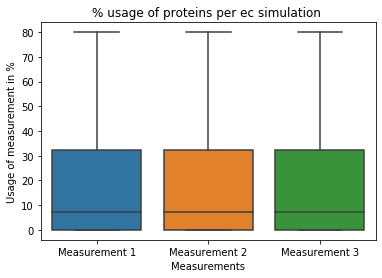

In [10]:
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns

df = perc_usages_1.to_frame()
df["perc_usages_2"] = perc_usages_2
df["perc_usages_3"] = perc_usages_3
df.columns = ["Measurement 1", "Measurement 2", "Measurement 3"]

sns.boxplot(x="variable", y="value", data=pd.melt(df[(df > 0) & (df < 100)]))
plt.xlabel('Measurements')
plt.ylabel('Usage of measurement in %')
plt.title('% usage of proteins per ec simulation ')
plt.savefig(f'{FIGURES}/ec_incorporation_perc_usage_box_ac')
plt.show()



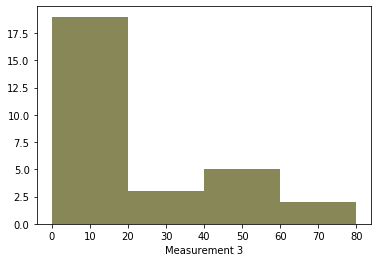

In [11]:
#df['pct'] = df['Location'].div(df.groupby('Hour')['Location'].transform('sum'))
#g = sns.FacetGrid(df, row="pct", hue="pct", aspect=15, height=.5, palette=pal)

perc_incorporation_pyr = pd.melt(df[(df > 0) & (df < 100)])
 
# Method 1: on the same Axis
sns.distplot( df[(df > 0) & (df < 100)].iloc[:,0] , color="skyblue", label="1", kde=False)
sns.distplot( df[(df > 0) & (df < 100)].iloc[:,1], color="red", label="2", kde=False)
sns.distplot( df[(df > 0) & (df < 100)].iloc[:,2], color="green", label="3", kde=False)


/Library/Python/3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



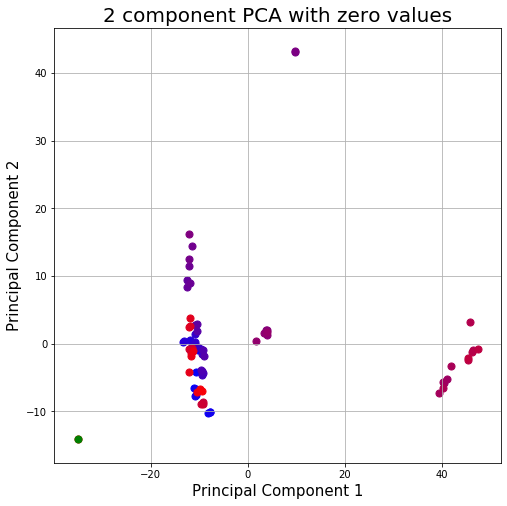

In [12]:
from sklearn.preprocessing import StandardScaler

# standardize data for pca 
# #features = ['sepal length', 'sepal width', 'petal length', 'petal width']# Separating out the features
pca_df_all_proteomics_and_pyr = pd.read_csv(proteomics_dataset, index_col="UP").loc[df.index,:]
pca_df_all_proteomics_and_pyr['pyr_1'] = abs_usages_1
pca_df_all_proteomics_and_pyr = pca_df_all_proteomics_and_pyr.T.dropna(axis='columns')
x = pca_df_all_proteomics_and_pyr.values
x = StandardScaler().fit_transform(x)

# run pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf.index = pca_df_all_proteomics_and_pyr.index

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA with zero values', fontsize = 20)

amount = len(principalDf.index)
for i in range(amount):
    c = [float(i)/float(amount), 0.0, float(amount-i)/float(amount)] #R,G,B
    ax.scatter(principalDf.loc[principalDf.index[i], 'principal component 1']
           , principalDf.loc[principalDf.index[i], 'principal component 2']
           , color = c 
           , s = 50)
ax.scatter(principalDf.loc["pyr_1", 'principal component 1']
           , principalDf.loc[principalDf.index[i], 'principal component 2']
           , color = "green"
           , s = 50)


#ax.legend(pca_df_all_proteomics_and_pyr.index)
ax.grid()
plt.savefig(f'{FIGURES}/')


/Library/Python/3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



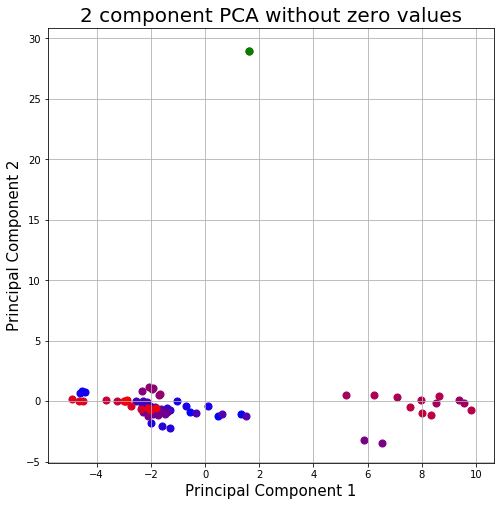

In [13]:
# standardize data for pca 
# #features = ['sepal length', 'sepal width', 'petal length', 'petal width']# Separating out the features
pca_df_all_proteomics_and_pyr = pd.read_csv(proteomics_dataset, index_col="UP").loc[df.index,:]
pca_df_all_proteomics_and_pyr['pyr_1'] = abs_usages_1
pca_df_all_proteomics_and_pyr = pca_df_all_proteomics_and_pyr[pca_df_all_proteomics_and_pyr['pyr_1'] > 0]
pca_df_all_proteomics_and_pyr = pca_df_all_proteomics_and_pyr.T.dropna(axis='columns')
x = pca_df_all_proteomics_and_pyr.values
x = StandardScaler().fit_transform(x)

# run pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf.index = pca_df_all_proteomics_and_pyr.index

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA without zero values', fontsize = 20)

amount = len(principalDf.index)
for i in range(amount):
    c = [float(i)/float(amount), 0.0, float(amount-i)/float(amount)] #R,G,B
    ax.scatter(principalDf.loc[principalDf.index[i], 'principal component 1']
           , principalDf.loc[principalDf.index[i], 'principal component 2']
           , color = c 
           , s = 50)
ax.scatter(principalDf.loc["pyr_1", 'principal component 1']
           , principalDf.loc[principalDf.index[i], 'principal component 2']
           , color = "green"
           , s = 50)

ax.grid()

In [26]:
pd.DataFrame({'ac_1':abs_usages_1, 'ac_2':abs_usages_2, 'ac_3':abs_usages_3}).to_csv(f'{INTERMEDIATE}/proteomics/acetate_usages.csv')


# Check sensibility
- try using fluxomics data to compare the fluxes to the values of the non-ec model

In [239]:
# load fluxomics data
fluxes = pd.read_csv(f"{RAW_EXTERNAL}/chemostat_flux.csv", index_col = "D [h-1]")["0.19"]

fluxes

D [h-1]
glucose consumption rate [mmol gdw-1 h-1]    2.80
GLC + ATP -> G6P                             2.84
G6P -> 6PG + NADPH                           1.24
6PG -> P5P + CO2 + NADPH                     0.97
G6P -> F6P                                   1.58
6PG -> T3P + PYR                             0.28
F6P + ATP -> 2T3P                            2.12
2P5P -> S7P + T3P                            0.31
P5P + E4P -> F6P + T3P                       0.23
S7P + T3P -> E4P + F6P                       0.31
T3P -> PGA + ATP + NADH                      4.72
PGA -> PEP                                   4.42
PEP -> PYR + ATP                             4.58
PYR -> AcCoA + CO2 + NADH                    4.64
OAA + AcCoA -> ICT                           2.88
ICT -> OGA + CO2 + NADPH                     1.56
OGA -> FUM + CO2 + 1.5*ATP + 2NADH           1.28
FUM -> MAL                                   2.61
MAL -> OAA + NADH                            3.52
MAL -> PYR + CO2 + NADH                   

In [240]:
ec_model_sol = ec_model_1.optimize()
ec_model_pfba = cobra.flux_analysis.pfba(ec_model_1)

In [242]:


# compare the 
type(ec_model_1.optimize().fluxes)
f = ec_model_1.optimize()
g = [i for i in range(0, len(f.fluxes)) if "EX_glc" in f.fluxes.index[i]]
f.fluxes[g]

# find reaction GLC + ATP -> G6P     
glc_metabolite = ec_model_1.metabolites.get_by_id("glc__D_c")
atp_metabolite = ec_model_1.metabolites.get_by_id("atp_c")
reactions_glc_atp = [i for i in model.reactions\
 if glc_metabolite in i.metabolites and atp_metabolite in i.metabolites]
hexokinase = reactions[0]
print("GLC + ATP -> G6P :",ec_model_sol[hexokinase.id])

# find flux glc atp 

# find reaction G6P -> 6PG + NADPH
g6p_metabolite = ec_model_1.metabolites.get_by_id("g6p_c")
nadph_metabolite = ec_model_1.metabolites.get_by_id("nadph_c")
nadp_reactions = [i for i in model.reactions\
 if nadph_metabolite in i.metabolites and g6p_metabolite in i.metabolites]
g6p_nadph = nadp_reactions[0]
print("G6P -> 6PG + NADPH :",ec_model_sol[g6p_nadph.id])


# find reaction G6P -> F6P
f6p_metabolite = ec_model_1.metabolites.get_by_id("f6p_c")
g6p_metabolite = ec_model_1.metabolites.get_by_id("g6p_c")
f6p_reactions = [i for i in model.reactions\
 if f6p_metabolite in i.metabolites and g6p_metabolite in i.metabolites]
f6p_reaction = f6p_reactions[0]
print("G6P -> F6P :",ec_model_sol[f6p_reaction.id])


# find reaction 6PG -> T3P + PYR
pyr_metabolite = ec_model_1.metabolites.get_by_id("pyr_c")
sixpgl_metabolite = ec_model_1.metabolites.get_by_id("6pgl_c")
pyr_reactions = [i for i in model.reactions\
 if pyr_metabolite in i.metabolites]# and sixpgl_metabolite in i.metabolites]
pyr_reaction = pyr_reactions[0]
print("6PG -> T3P + PYR :",ec_model_sol[pyr_reaction.id])


# find reaction F6P + ATP -> 2T3P
pyr_reactions = [i for i in model.reactions\
 if f6p_metabolite in i.metabolites and atp_metabolite in i.metabolites]
f6p_reaction = pyr_reactions[0]
print("F6P + ATP -> 2T3P :",ec_model_sol[f6p_reaction.id])


# find reaction PGA -> PEP
pep_metabolite = ec_model_1.metabolites.get_by_id("pep_c")
pga_reactions = [i for i in model.reactions\
 if pep_metabolite in i.metabolites]# and atp_metabolite in i.metabolites]
pga_reaction = pga_reactions[0]
#ec_model_1.optimize()[pga_reactions.id]

# find reaction PEP -> PYR + ATP
pep_metabolite = ec_model_1.metabolites.get_by_id("pep_c")
peppyr_reactions = [i for i in model.reactions\
 if pep_metabolite in i.metabolites and atp_metabolite in i.metabolites]
peppyr_reaction = peppyr_reactions[1]
print("PEP -> PYR + ATP :",ec_model_sol[peppyr_reaction.id])


# find reaction PYR -> AcCoA + CO2 + NADH
pep_metabolite = ec_model_1.metabolites.get_by_id("pep_c")
co2_metabolite = ec_model_1.metabolites.get_by_id("co2_c")
accoa_metabolite = ec_model_1.metabolites.get_by_id("accoa_c")
pyraccoa_reactions = [i for i in model.reactions\
 if pyr_metabolite in i.metabolites and co2_metabolite in i.metabolites and accoa_metabolite in i.metabolites]
#pyraccoa_reaction = pyraccoa_reactions[0]
#ec_model_1.optimize()[pyraccoa_reaction.id]

# find reaction FUM -> MAL
fum_metabolite = ec_model_1.metabolites.get_by_id("fum_c")
co2_metabolite = ec_model_1.metabolites.get_by_id("co2_c")
accoa_metabolite = ec_model_1.metabolites.get_by_id("accoa_c")
pyraccoa_reactions = [i for i in model.reactions\
 if pyr_metabolite in i.metabolites and co2_metabolite in i.metabolites and accoa_metabolite in i.metabolites]
#pyraccoa_reaction = pyraccoa_reactions[0]
#ec_model_1.optimize()[pyraccoa_reaction.id]


# find reaction AcCoA -> Acetate + ATP
ac_metabolite = ec_model_1.metabolites.get_by_id("ac_c")
accoaac_reactions = [i for i in model.reactions\
 if ac_metabolite in i.metabolites and accoa_metabolite in i.metabolites and atp_metabolite in i.metabolites]
accoaac_reaction = accoaac_reactions[0]
print("AcCoA -> Acetate + ATP: " ,ec_model_sol[accoaac_reaction.id])

# find reaction NADPH -> NADH
nadh_metabolite = ec_model_1.metabolites.get_by_id("nadh_c")
nadpnadh_reactions = [i for i in model.reactions\
 if nadh_metabolite in i.metabolites and nadph_metabolite in i.metabolites]
nadpnadh_reaction = nadpnadh_reactions[0]
#ec_model_1.optimize()[nadpnadh_reaction.id]

GLC + ATP -> G6P : 3.076127514751424
g6p nadph : 3.076127514751424
G6P -> F6P : 2.5168621099324184
6PG -> T3P + PYR : 0.0
F6P + ATP -> 2T3P : 0.2338547795227729
PEP -> PYR + ATP : 0.0
AcCoA -> Acetate + ATP:  0.0


In [237]:

#E. coli model:
ssl._create_default_https_context = ssl._create_unverified_context
wget.download("https://raw.githubusercontent.com/BenjaSanchez/notebooks/master/e_coli_simulations/eciML1515.xml")
unc_model = cobra.io.read_sbml_model("eciML1515.xml")
os.remove("eciML1515.xml")

unc_model_sol = unc_model.optimize()
#unc_model_pfba_sol = cobra.flux_analysis.pfba(unc_model_sol)

AttributeError: 'Solution' object has no attribute 'reactions'

In [244]:
# load fluxomics data
fluxes = pd.read_csv(f"{RAW_EXTERNAL}/chemostat_flux.csv", index_col = "D [h-1]")["0.19"]


# compare the 
type(ec_model_1.optimize().fluxes)
f = ec_model_1.optimize()
g = [i for i in range(0, len(f.fluxes)) if "EX_glc" in f.fluxes.index[i]]
f.fluxes[g]
unc_model.medium

# find reaction GLC + ATP -> G6P     
glc_metabolite = ec_model_1.metabolites.get_by_id("glc__D_c")
atp_metabolite = ec_model_1.metabolites.get_by_id("atp_c")
reactions_glc_atp = [i for i in model.reactions\
 if glc_metabolite in i.metabolites and atp_metabolite in i.metabolites]
hexokinase = reactions[0]
print("GLC + ATP -> G6P :",unc_model_sol[hexokinase.id])

# find flux glc atp 

# find reaction G6P -> 6PG + NADPH
g6p_metabolite = ec_model_1.metabolites.get_by_id("g6p_c")
nadph_metabolite = ec_model_1.metabolites.get_by_id("nadph_c")
nadp_reactions = [i for i in model.reactions\
 if nadph_metabolite in i.metabolites and g6p_metabolite in i.metabolites]
g6p_nadph = nadp_reactions[0]
print("G6P -> 6PG + NADPH :",unc_model_sol[g6p_nadph.id])


# find reaction G6P -> F6P
f6p_metabolite = ec_model_1.metabolites.get_by_id("f6p_c")
g6p_metabolite = ec_model_1.metabolites.get_by_id("g6p_c")
f6p_reactions = [i for i in model.reactions\
 if f6p_metabolite in i.metabolites and g6p_metabolite in i.metabolites]
f6p_reaction = f6p_reactions[0]
print("G6P -> F6P :",unc_model_sol[f6p_reaction.id])


# find reaction 6PG -> T3P + PYR
pyr_metabolite = ec_model_1.metabolites.get_by_id("pyr_c")
sixpgl_metabolite = ec_model_1.metabolites.get_by_id("6pgl_c")
pyr_reactions = [i for i in model.reactions\
 if pyr_metabolite in i.metabolites]# and sixpgl_metabolite in i.metabolites]
pyr_reaction = pyr_reactions[0]
print("6PG -> T3P + PYR :",unc_model_sol[pyr_reaction.id])


# find reaction F6P + ATP -> 2T3P
pyr_reactions = [i for i in model.reactions\
 if f6p_metabolite in i.metabolites and atp_metabolite in i.metabolites]
f6p_reaction = pyr_reactions[0]
print("F6P + ATP -> 2T3P :",unc_model_sol[f6p_reaction.id])


# find reaction PGA -> PEP
pep_metabolite = ec_model_1.metabolites.get_by_id("pep_c")
pga_reactions = [i for i in model.reactions\
 if pep_metabolite in i.metabolites]# and atp_metabolite in i.metabolites]
pga_reaction = pga_reactions[0]
#ec_model_1.optimize()[pga_reactions.id]

# find reaction PEP -> PYR + ATP
pep_metabolite = ec_model_1.metabolites.get_by_id("pep_c")
peppyr_reactions = [i for i in model.reactions\
 if pep_metabolite in i.metabolites and atp_metabolite in i.metabolites]
peppyr_reaction = peppyr_reactions[1]
print("PEP -> PYR + ATP :",unc_model_sol[peppyr_reaction.id])


# find reaction PYR -> AcCoA + CO2 + NADH
pep_metabolite = ec_model_1.metabolites.get_by_id("pep_c")
co2_metabolite = ec_model_1.metabolites.get_by_id("co2_c")
accoa_metabolite = ec_model_1.metabolites.get_by_id("accoa_c")
pyraccoa_reactions = [i for i in model.reactions\
 if pyr_metabolite in i.metabolites and co2_metabolite in i.metabolites and accoa_metabolite in i.metabolites]
#pyraccoa_reaction = pyraccoa_reactions[0]
#ec_model_1.optimize()[pyraccoa_reaction.id]

# find reaction FUM -> MAL
fum_metabolite = ec_model_1.metabolites.get_by_id("fum_c")
co2_metabolite = ec_model_1.metabolites.get_by_id("co2_c")
accoa_metabolite = ec_model_1.metabolites.get_by_id("accoa_c")
pyraccoa_reactions = [i for i in model.reactions\
 if pyr_metabolite in i.metabolites and co2_metabolite in i.metabolites and accoa_metabolite in i.metabolites]
#pyraccoa_reaction = pyraccoa_reactions[0]
#ec_model_1.optimize()[pyraccoa_reaction.id]


# find reaction AcCoA -> Acetate + ATP
ac_metabolite = ec_model_1.metabolites.get_by_id("ac_c")
accoaac_reactions = [i for i in model.reactions\
 if ac_metabolite in i.metabolites and accoa_metabolite in i.metabolites and atp_metabolite in i.metabolites]
accoaac_reaction = accoaac_reactions[0]
print("AcCoA -> Acetate + ATP: " ,unc_model_sol[accoaac_reaction.id])

# find reaction NADPH -> NADH
nadh_metabolite = ec_model_1.metabolites.get_by_id("nadh_c")
nadpnadh_reactions = [i for i in model.reactions\
 if nadh_metabolite in i.metabolites and nadph_metabolite in i.metabolites]
nadpnadh_reaction = nadpnadh_reactions[0]
#ec_model_1.optimize()[nadpnadh_reaction.id]

GLC + ATP -> G6P : 2.355367839801507
G6P -> 6PG + NADPH : 2.355367839801507
G6P -> F6P : 7.644632160198492
6PG -> T3P + PYR : 0.0
F6P + ATP -> 2T3P : 0.0
PEP -> PYR + ATP : 0.0
AcCoA -> Acetate + ATP:  0.0
